In [1]:
# 1. 표준 라이브러리
import sys
from pathlib import Path
import platform
import time
import json
import os
import joblib
from datetime import datetime
from typing import Optional
from dataclasses import dataclass


# 2. 서드파티 라이브러리 

# 2-1. 시각화
import plotly.express as px

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns

# 2-2. 
import shap
from imblearn.pipeline import Pipeline as ImbPipeline
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, make_scorer, recall_score, 
    precision_score, f1_score, fbeta_score, average_precision_score, balanced_accuracy_score, precision_recall_fscore_support
)
from scipy.stats import uniform, randint
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.base import BaseEstimator


import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")

sys.path.append(str(Path.cwd().parent))
from utils import DATA_DIR, MODEL_DIR

/Users/eric/yeeun/anaconda3/envs/smartfarm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

mpl.rcParams['axes.unicode_minus'] = False
# 폰트 개인 경로에 맞춰서 변경
# FONT_DIR = Path("/path/to/fonts")
# font_path = FONT_DIR / 'FREESENTATION-6SEMIBOLD.ttf'
# prop = fm.FontProperties(fname=font_path)

In [3]:
pandas_kwargs = {
    'parse_dates': ['검정일자'],
    'date_format': '%Y-%m-%d'
}

milk: pd.DataFrame = pd.read_csv(DATA_DIR /'interim' / 'milk.csv', **pandas_kwargs)
milk.head()

,농장아이디,개체번호,검정일자,누적착유일(연계),유지방율,유단백,무지고형분,체세포수,MUN,305일유량,...,공태일수,유량,질병군,우유등급,비유초기평균MUN.1,비유최고도달일수_log,건유전마지막유량_log,공태일수_log,출생년도,PF비
0,21133,2.007121e+13,2021-03-18,445,6.60,3.28,8.87,274,11.6,15158.0,...,619,76169939,0,2등급이하,NaN,4.143135,4.330733,6.429719,2007,0.496970
1,21133,2.007121e+13,2021-04-28,486,3.64,3.33,8.91,166,11.0,15158.0,...,619,76170244,0,1등급,NaN,4.143135,4.330733,6.429719,2007,0.914835
2,21133,2.007121e+13,2021-05-20,508,2.61,3.35,9.14,156,10.8,15158.0,...,619,76170487,0,1등급,NaN,4.143135,4.330733,6.429719,2007,1.283525
3,21133,2.007121e+13,2021-06-25,544,3.75,3.49,8.99,307,14.1,15158.0,...,619,76170734,0,2등급이하,NaN,4.143135,4.330733,6.429719,2007,0.930667
4,21133,2.007121e+13,2021-07-07,556,3.68,3.74,9.31,34,16.2,15158.0,...,619,76170903,0,1등급,NaN,4.143135,4.330733,6.429719,2007,1.016304


In [4]:
df = milk

In [5]:
df['1등급'] = df['우유등급'].map({
    '1등급': 0,
    '2등급이하': 1
})

In [6]:
target='1등급'
features = [
    '누적착유일(연계)',
    '전산차비유지속성',
    '현재산차비유지속성',
    '비유최고도달일수_log',
    '건유전마지막유량_log',
    '전산차건유전유량',
    '산차',
    '농후사료급여량(연계)',
    '공태일수_log'
]

In [7]:
train = df[df['검정일자'].dt.year == 2020]
test = df[df['검정일자'].dt.year == 2021]

X_train, X_test = train[features], test[features]
y_train, y_test = train['1등급'], test['1등급']

In [ ]:
# ============================================
# 1. 클래스 비율 확인
# ============================================
print("="*60)
print("클래스 분포 분석")
print("="*60)
print(y_train.value_counts().sort_index())
print(f"\n비율:")
print(y_train.value_counts(normalize=True).sort_index())

# ✅ 수정: 0이 1등급(다수), 1이 그외(소수)
majority_count = (y_train == 0).sum()   # 1등급 (다수) - 약 90%
minority_count = (y_train == 1).sum()   # 그외 (소수) - 약 10%

print(f"\n클래스 구성:")
print(f"   0 (1등급, 다수): {majority_count}개 ({majority_count/len(y_train)*100:.1f}%)")
print(f"   1 (그외, 소수): {minority_count}개 ({minority_count/len(y_train)*100:.1f}%)")

# ✅ scale_pos_weight: 양성 클래스(1=그외=소수)에 대한 가중치
# 공식: (다수 클래스 개수) / (소수 클래스 개수)
scale_pos_weight = majority_count / minority_count

print(f"\n계산된 scale_pos_weight: {scale_pos_weight:.2f}")
print(f"   → LightGBM은 자동으로 클래스 1(그외)에 이 가중치 적용")

# 결측치 확인
print("\n결측치 현황:")
missing_info = pd.DataFrame({
    'Feature': X_train.columns,
    '결측_개수': X_train.isnull().sum().values,
    '결측_비율(%)': (X_train.isnull().mean() * 100).values
}).sort_values('결측_비율(%)', ascending=False)
print(missing_info.head(10))
print(f"\n전체 결측 비율: {X_train.isnull().mean().mean()*100:.1f}%")
print(f"Feature 개수: {X_train.shape[1]}개")

# ============================================
# 2. Pipeline 구성
# ============================================

pipeline = ImbPipeline([
    ('model', LGBMClassifier(
        objective='binary',
        device='cpu',
        random_state=42,
        verbosity=-1,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight,  # ✅ 자동으로 pos_label=1에 적용
        force_col_wise=True
    ))
])

print("\n✅ Pipeline 구성:")
print("   1. LGBMClassifier (GPU)")
print(f"      - scale_pos_weight={scale_pos_weight:.2f} (클래스 1=그외 가중치)")

# ============================================
# 3. 파라미터 분포
# ============================================
print(f"\n소수 클래스(1=그외) 샘플 수: {minority_count}개")

param_distributions = {
    # 🔥 LightGBM 파라미터 - 소수 클래스 민감도 향상
    'model__n_estimators': randint(300, 1000),
    'model__learning_rate': uniform(0.005, 0.045),
    'model__max_depth': randint(3, 8),
    'model__num_leaves': randint(15, 80),
    'model__min_child_samples': randint(5, 50),
    'model__subsample': uniform(0.6, 0.4),
    'model__colsample_bytree': uniform(0.6, 0.4),
    'model__min_child_weight': [1e-5, 1e-4, 1e-3, 1e-2],
    'model__reg_alpha': uniform(0, 0.5),
    'model__reg_lambda': uniform(0, 0.5),
}


# ============================================
# 4. Scoring 설정
# ============================================

# ✅ 이제 pos_label=1이 기본값이므로 생략 가능!
# 하지만 명확성을 위해 명시하는 것 추천 (특히 팀 협업 시)

# def constrained_pr_auc_scorer(y_true, y_pred_proba):
#     """
#     Recall >= 0.5 제약 하에서 PR-AUC 최대화
    
#     로직:
#     1. 현재 확률로 최적 임계값 찾기
#     2. Recall >= 0.5 만족하는 임계값 중 최대 Precision 찾기
#     3. 그때의 PR-AUC 반환
#     4. 만족하는 임계값 없으면 매우 낮은 점수 반환
#     """
#     from sklearn.metrics import precision_recall_curve, auc
    
#     # PR 곡선 계산
#     precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_proba, pos_label=1)
    
#     # Recall >= 0.5 만족하는 인덱스 찾기
#     valid_idx = np.where(recalls >= 0.5)[0]
    
#     if len(valid_idx) == 0:
#         # Recall 0.5 달성 불가 → 매우 낮은 페널티 점수
#         return -1.0
    
#     # Recall >= 0.5 구간의 PR-AUC 계산
#     # 방법 1: 전체 PR-AUC 반환 (하지만 Recall 0.5 제약 반영)
#     valid_precisions = precisions[valid_idx]
#     valid_recalls = recalls[valid_idx]
    
#     # Recall 구간 [0.5, 1.0]에서의 AUC
#     # 간단하게: Recall >= 0.5인 구간의 평균 Precision 사용
#     score = np.mean(valid_precisions)
    
#     return score


scoring = {
    'recall': make_scorer(recall_score),
    'f2': make_scorer(fbeta_score, beta=2),              
    'pr_auc': make_scorer(average_precision_score, response_method='predict_proba'),
    'precision': make_scorer(precision_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0, average='macro'),
    'roc_auc': 'roc_auc'                                           
}

main_score = 'pr_auc'

print("\n✅ Scoring 전략:")
print(f"   메인 목표: {main_score.upper()}")
print(f"   타깃: 클래스 1 (그외) 검출 최적화")
print(f"   pos_label: 1 (기본값, 생략 가능)")

# ============================================
# 5. Stratified K-Fold
# ============================================
n_folds = 5
n_iter = 150
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)


print(f"\n교차검증 Folds: {n_folds}")
print(f"랜덤 샘플링 조합 수: {n_iter}개")
print(f"총 Fits: {n_iter} × {n_folds} = {n_iter * n_folds}")

# ============================================
# 6. RandomizedSearchCV 실행
# ============================================

print("\n" + "="*60)
print("🚀 RandomizedSearchCV 시작!")
print("="*60)

lgbm_random = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=n_iter,
    cv=cv,
    scoring=scoring,
    refit=main_score,
    verbose=3,
    random_state=42,
    n_jobs=-1,
    error_score=np.nan 
)

start_actual = time.time()
lgbm_random.fit(X_train, y_train)
actual_time = time.time() - start_actual

# ============================================
# 7. 결과 출력
# ============================================
print("\n" + "="*60)
print("✅ 완료!")
print("="*60)
print(f"⏱️  소요 시간: {actual_time/60:.1f}분 ({actual_time:.0f}초)")

print(f"\n🏆 최고 {main_score.upper()} (CV): {lgbm_random.best_score_:.4f}")

print("\n📋 최적 파라미터:")
for key, value in sorted(lgbm_random.best_params_.items()):
    if isinstance(value, float):
        print(f"   {key}: {value:.4f}")
    else:
        print(f"   {key}: {value}")


In [ ]:

# ============================================
# 8. 전체 결과 비교
# ============================================
results_df = pd.DataFrame(lgbm_random.cv_results_)

scoring_cols = [f'mean_test_{score}' for score in scoring.keys()]

comparison_cols = [f'rank_test_{main_score}'] + scoring_cols + ['params']

print("\n" + "="*60)
print(f"📊 상위 10개 파라미터 조합 ({main_score.upper()} 기준)")
print("="*60)
top_10 = results_df[comparison_cols].sort_values(f'rank_test_{main_score}').head(10)

for idx, row in top_10.iterrows():
    rank = int(row[f'rank_test_{main_score}'])
    pr_auc = row[f'mean_test_pr_auc']
    recall = row['mean_test_recall']
    f2 = row['mean_test_f2']
    precision = row['mean_test_precision']
    f1 = row['mean_test_f1']
    
    print(f"\n#{rank} - {main_score.upper()}: {row[f'mean_test_{main_score}']:.4f} | Recall: {recall:.4f}")
    print(f"   F2: {f2:.3f} | Precision: {precision:.3f} | F1: {f1:.3f}")
    
    params = row['params']
    print(f"   Model: lr={params.get('model__learning_rate', 0):.4f}, "
          f"depth={params.get('model__max_depth', 0)}, "
          f"leaves={params.get('model__num_leaves', 0)}")

# ============================================
# 9. 테스트 세트 평가
# ============================================
print("\n" + "="*60)
print("🧪 테스트 세트 평가")
print("="*60)

best_model = lgbm_random.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# ✅ 클래스 1(그외)의 확률 추출
y_pred_proba_minority = y_pred_proba[:, 1]  # ✅ 인덱스 1 = 클래스 1 = 그외

print(classification_report(
    y_test, y_pred, 
    target_names=['0 (1등급, 다수)', '1 (그외, 소수)']
))

print("\n혼동 행렬:")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index=['실제_0 (1등급)', '실제_1 (그외)'],
                     columns=['예측_0 (1등급)', '예측_1 (그외)'])
print(cm_df)

# ✅ 혼동 행렬 해석 수정
# confusion_matrix 구조:
#              예측_0  예측_1
# 실제_0 (1등급)  TN      FP
# 실제_1 (그외)   FN      TP

tn, fp, fn, tp = cm.ravel()

print("\n💼 비즈니스 해석 (소수 클래스=1=그외 기준):")
print(f"   ✅ 정확한 분류: {tn + tp}개 ({(tn+tp)/len(y_test)*100:.1f}%)")
print(f"   ⚠️  오탐 (FP): {fp}개 → 1등급을 그외로 오판 (재검사 필요)")
print(f"   🚨 미탐 (FN): {fn}개 → 그외를 1등급으로 오판 (치명적!)")

# ✅ Recall 계산: TP / (TP + FN)
if tp + fn > 0:
    recall_pct = tp/(tp+fn)*100
    print(f"\n   📊 소수 클래스(1=그외) Recall: {recall_pct:.1f}%")
    print(f"      → 그외 {tp+fn}개 중 {tp}개 검출 ({fn}개 놓침)")
else:
    print(f"\n   📊 소수 클래스(1=그외) Recall: N/A")

# ✅ Precision 계산: TP / (TP + FP)
if tp + fp > 0:
    precision_pct = tp/(tp+fp)*100
    print(f"   📊 소수 클래스(1=그외) Precision: {precision_pct:.1f}%")
    print(f"      → 그외 판정 {tp+fp}개 중 {tp}개 정답")
else:
    print(f"   📊 소수 클래스(1=그외) Precision: N/A")

test_roc_auc = roc_auc_score(y_test, y_pred_proba_minority)
print(f"   📊 ROC-AUC: {test_roc_auc:.4f}")

# ============================================
# 10. 🔥 임계값 조정으로 추가 개선
# ============================================
from sklearn.metrics import precision_recall_curve, average_precision_score

# ✅ pos_label=1 (그외) 기준으로 PR 곡선 계산
precisions, recalls, thresholds = precision_recall_curve(
    y_test, y_pred_proba_minority
)

# Recall 80% 보장
target_recall = 0.80
idx = np.where(recalls >= target_recall)[0]

if len(idx) > 0:
    best_idx = idx[np.argmax(precisions[idx])]
    optimal_threshold = thresholds[best_idx]
    
    print("\n" + "="*60)
    print(f"🎯 Recall {target_recall*100}% 보장 시 최적 임계값")
    print("="*60)
    print(f"최적 임계값: {optimal_threshold:.3f} (기본값 0.5)")
    print(f"Precision: {precisions[best_idx]:.3f}")
    print(f"Recall: {recalls[best_idx]:.3f}")
    
    # ✅ 임계값 조정: 확률 >= threshold이면 클래스 1(그외)로 예측
    y_pred_adjusted = (y_pred_proba_minority >= optimal_threshold).astype(int)
    
    cm_adj = confusion_matrix(y_test, y_pred_adjusted)
    tn2, fp2, fn2, tp2 = cm_adj.ravel()
    
    print(f"\n조정 효과:")
    print(f"   미탐(FN) 감소: {fn} → {fn2} (개선: {fn-fn2}개)")
    print(f"   오탐(FP) 증가: {fp} → {fp2} (증가: {fp2-fp}개)")
    
    if tp + fn > 0 and tp2 + fn2 > 0:
        print(f"   Recall 개선: {tp/(tp+fn)*100:.1f}% → {tp2/(tp2+fn2)*100:.1f}%")
    
    if fn > fn2:
        print(f"   💡 그외를 1등급으로 오판하는 치명적 오류 {fn-fn2}개 감소!")
else:
    print(f"\n⚠️  Recall {target_recall*100}% 달성 불가 (최대 Recall: {recalls.max():.2%})")

# ============================================
# 11. 변수 중요도 확인
# ============================================
print("\n" + "="*60)
print("📊 변수 중요도 Top 10")
print("="*60)

final_model = best_model.named_steps['model']
feature_names = list(X_train.columns)

n_features_used = len(final_model.feature_importances_)
feature_names = feature_names[:n_features_used]

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print(importance_df.head(10).to_string(index=False))

# ============================================
# 12. 교차검증 vs 테스트 성능 비교
# ============================================
print("\n" + "="*60)
print("📈 성능 비교: 교차검증 vs 테스트")
print("="*60)

# ✅ pos_label=1 기본값 사용
test_metrics = {
    'PR-AUC': average_precision_score(y_test, y_pred_proba_minority),
    'Recall': recall_score(y_test, y_pred),
    'F2': fbeta_score(y_test, y_pred, beta=2),
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'F1': f1_score(y_test, y_pred, zero_division=0),
    'ROC-AUC': test_roc_auc
}

print(f"{'지표':<15} {'교차검증 (CV)':<20} {'테스트':<15} {'차이':<10}")
print("-" * 60)

for metric in ['PR-AUC', 'Recall', 'F2', 'Precision', 'F1', 'ROC-AUC']:
    cv_key = metric.lower().replace('-', '_')
    cv_score = results_df.loc[results_df[f'rank_test_{main_score}'] == 1, f'mean_test_{cv_key}'].values[0]
    test_score = test_metrics[metric]
    diff = test_score - cv_score
    
    diff_str = f"{diff:+.4f}"
    if abs(diff) > 0.05:
        diff_str += " ⚠️"
    
    print(f"{metric:<15} {cv_score:<20.4f} {test_score:<15.4f} {diff_str}")

# ============================================
# 13. 최종 요약
# ============================================
print("\n" + "="*60)
print(f"📝 최종 요약 ({main_score.upper()} 최적화)")
print("="*60)
print(f"✅ 최적 모델 {main_score.upper()} (CV): {lgbm_random.best_score_:.4f}")
print(f"✅ 테스트 Recall: {test_metrics['Recall']*100:.1f}% (그외 검출률)")
print(f"✅ 테스트 Precision: {test_metrics['Precision']*100:.1f}% (그외 판정 정확도)")
print(f"✅ 테스트 F1: {test_metrics['F1']:.4f}")
print(f"✅ 치명적 오류(미탐 FN): {fn}개 / {tp+fn}개")
print(f"⏱️  총 소요 시간: {actual_time/60:.1f}분")

print("\n💡 핵심 포인트:")
print(f"   - 그외(1) {tp+fn}개 중 {tp}개 검출 ({tp/(tp+fn)*100:.1f}%)")
print(f"   - 놓친 그외: {fn}개")
print(f"   - 오탐 (1등급→그외): {fp}개 (재검사 필요)")

# ============================================
# 14. 모델 + 파라미터 저장
# ============================================
print("\n" + "="*60)
print("💾 모델 및 파라미터 저장")
print("="*60)

save_model_input = input("모델을 저장하시겠습니까? (y/n): ")
if save_model_input.lower() == 'y':
    
    # MODEL_DIR이 정의되지 않은 경우 현재 디렉토리 사용
    try:
        MODEL_DIR = Path(MODEL_DIR)
    except:
        MODEL_DIR = Path('.')
        print(f"⚠️  MODEL_DIR 미정의, 현재 디렉토리 사용: {MODEL_DIR.absolute()}")
    
    MODEL_DIR.mkdir(exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    model_filename = MODEL_DIR / f'best_lgbm_{main_score}_optimized_{timestamp}.pkl'
    params_filename = MODEL_DIR / f'best_params_{main_score}_{timestamp}.json'
    metrics_filename = MODEL_DIR / f'test_metrics_{main_score}_{timestamp}.json'
    results_filename = MODEL_DIR / f'cv_results_{main_score}_{timestamp}.csv'
    
    # 1. 모델 저장
    joblib.dump(best_model, model_filename)
    print(f"✅ 모델 저장: {model_filename}")
    
    # 2. 파라미터 저장
    best_params_serializable = {}
    for key, value in lgbm_random.best_params_.items():
        if isinstance(value, (np.integer, np.floating)):
            best_params_serializable[key] = float(value) if isinstance(value, np.floating) else int(value)
        else:
            best_params_serializable[key] = value
    
    params_info = {
        'best_params': best_params_serializable,
        f'best_{main_score}_score': float(lgbm_random.best_score_),
        'optimization_target': main_score,
        'cv_folds': n_folds,
        'n_iter': n_iter,
        'timestamp': timestamp,
        'class_labels': {
            '0': '1등급 (다수)',
            '1': '그외 (소수)'
        },
        'minority_count': int(minority_count),
        'majority_count': int(majority_count),
        'scale_pos_weight': float(scale_pos_weight)
    }
    
    with open(params_filename, 'w', encoding='utf-8') as f:
        json.dump(params_info, f, indent=2, ensure_ascii=False)
    print(f"✅ 파라미터 저장: {params_filename}")
    
    # 3. 테스트 성능 저장
    test_metrics_serializable = {
        key: float(value) if isinstance(value, (np.floating, np.integer)) else value
        for key, value in test_metrics.items()
    }
    
    metrics_info = {
        'test_metrics': test_metrics_serializable,
        'confusion_matrix': {
            'tn': int(tn),  # 1등급 → 1등급 (정답)
            'fp': int(fp),  # 1등급 → 그외 (오탐)
            'fn': int(fn),  # 그외 → 1등급 (미탐, 치명적!)
            'tp': int(tp)   # 그외 → 그외 (정답)
        },
        'business_interpretation': {
            'total_minority': int(tp + fn),      # 실제 그외 개수
            'detected_minority': int(tp),        # 검출된 그외
            'missed_minority': int(fn),          # 놓친 그외 (치명적)
            'recall_percentage': float(tp/(tp+fn)*100) if (tp+fn) > 0 else 0,
            'false_alarms': int(fp)              # 1등급을 그외로 오판
        },
        'timestamp': timestamp
    }
    
    with open(metrics_filename, 'w', encoding='utf-8') as f:
        json.dump(metrics_info, f, indent=2, ensure_ascii=False)
    print(f"✅ 테스트 성능 저장: {metrics_filename}")
    
    # 4. CV 결과 저장
    results_df.to_csv(results_filename, index=False, encoding='utf-8')
    print(f"✅ CV 결과 저장: {results_filename}")
    
    print("\n📦 저장된 파일 요약:")
    print(f"1. 모델: {model_filename.name}")
    print(f"2. 파라미터: {params_filename.name}")
    print(f"3. 성능: {metrics_filename.name}")
    print(f"4. CV결과: {results_filename.name}")
    
else:
    print("모델 저장 생략")

print("\n" + "="*60)
print("🎉 모든 작업 완료!")
print("="*60)

In [ ]:
@dataclass
class ClassificationResult:
    accuracy: float
    precision: float
    recall: float
    f1: float
    roc_auc: float
    pr_auc: float
    report: str
    
    def to_dict(self):
        return self.__dict__
    

class BinaryClassifierTester:
    def __init__(self, root):
        self.root = root
    
    def execute(self, model: Optional[BaseEstimator], name: Optional[str], ext: Optional[str], X_test: pd.DataFrame, y_test: pd.DataFrame, average: str = 'binary'):
        pass
    
    def load_model(self, name: str, ext: str = 'pkl') -> BaseEstimator:
        loaded_model = joblib.load(self.root / f'{name}.{ext}')
        return loaded_model
    
    def test(self, model: BaseEstimator, X_test: pd.DataFrame, y_test: pd.DataFrame, average: str = 'binary'):
        # 테스트셋 성능 평가
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_prob, average=average)

        report = classification_report(y_test, y_pred, digits=3)
        bal_acc = balanced_accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)
        pr_auc = average_precision_score(y_test, y_prob)
        
        return ClassificationResult(
            accuracy=bal_acc,
            precision=precision,
            recall=recall,
            f1 = f1,
            roc_auc=roc_auc,
            pr_auc=pr_auc,
            report=report
        )
        
    def show_result(self, result: ClassificationResult):
        print("\nClassification Report (Test Set):")
        print(result.report)
        print(f"\nAccuracy (Test Set): {result.accuracy:.3f}")
        print(f"ROC-AUC (Test Set): {result.roc_auc:.3f}")
        print(f"PR-AUC (Test Set): {result.pr_auc:.3f}")
        print()
        

In [9]:
models = [
    'best_lgbm_pr_auc_optimized_20251107_125534',
]

In [10]:
loaded_model = joblib.load(MODEL_DIR / 'best_lgbm_pr_auc_optimized_20251107_125534.pkl')
predictions = loaded_model.predict(X_test)

In [ ]:
params = loaded_model.named_steps['model'].get_params()

params['n_estimators'] = 10000
params['num_leaves'] = 10
params['max_depth'] = 5
params['verbosity'] = 1

In [ ]:
params

In [ ]:
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# pipeline = ImbPipeline([
#     ('model', LGBMClassifier(**params))
# ])

lgbm_model = LGBMClassifier(
    **params
)

lgbm_model.fit(
    X_train2, y_train2,
    eval_set=[(X_valid, y_valid)],  # train, valid 둘 다
    eval_names=['train', 'valid'],  # 이름 지정
    eval_metric=['auc_pr', 'recall'],  # PR-AUC (불균형 데이터에 적합)
    callbacks=[
        early_stopping(stopping_rounds=10000, verbose=True),
        log_evaluation(period=100)  # 100 iteration마다 출력
    ]
)


In [ ]:
# ============================================
# 1. Recall 평가 함수
# ============================================
def recall_eval(y_pred, dtrain):
    """
    Native API용 Recall 평가 함수
    
    Parameters:
    - y_pred: 예측 확률 (0~1)
    - dtrain: LightGBM Dataset
    
    Returns:
    - metric_name, score, is_higher_better
    """
    y_true = dtrain.get_label()
    y_pred_binary = (y_pred > 0.5).astype(int)
    score = recall_score(y_true, y_pred_binary)
    return 'recall', score, True

def pr_auc_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    score = average_precision_score(y_true, y_pred)
    return 'pr_auc', score, True

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred_binary = (y_pred > 0.5).astype(int)
    score = f1_score(y_true, y_pred_binary)
    return 'f1_score', score, True

# ============================================
# 2. Dataset 생성
# ============================================
train_data = lgb.Dataset(X_train2, label=y_train2)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

# ============================================
# 3. 파라미터 설정
# ============================================
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'None',  # 🔥 기본 메트릭 끄기
    'learning_rate': 0.04330431113219459,
    'max_depth': 7,
    'num_leaves': 72,
    'min_child_samples': 36,
    'min_child_weight': 0.0001,
    'reg_alpha': 0.28565947095978705,
    'reg_lambda': 0.3310560050532823,
    'subsample': 0.8175115631989597,
    'colsample_bytree': 0.63045234379612,
    'scale_pos_weight': 7.16811515480717,
    'random_state': 42,
    'verbosity': 1,
    'force_col_wise': True,
    'n_jobs': -1
}

# ============================================
# 4. 학습 (Recall 기준)
# ============================================
print("="*60)
print("🚀 LightGBM 학습 시작 (Recall 최적화)")
print("="*60)

evals_result = {}

model = lgb.train(
    params,
    train_data,
    num_boost_round=10000,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    feval=f1_eval,  # 🔥 Recall 기준
    callbacks=[
        lgb.early_stopping(stopping_rounds=10000, verbose=True),
        lgb.log_evaluation(period=100),
        lgb.record_evaluation(evals_result)
    ]
)

# ============================================
# 5. 결과 확인
# ============================================
print("\n" + "="*60)
print("✅ 학습 완료")
print("="*60)

best_iter = model.best_iteration
print(f"\n최적 Iteration: {best_iter}")

print("\n📊 최종 성능:")
# train_recall = evals_result['train']['recall'][best_iter-1]
# valid_recall = evals_result['valid']['recall'][best_iter-1]

# print(f"Train Recall: {train_recall:.4f}")
# print(f"Valid Recall: {valid_recall:.4f}")

# if valid_recall >= 0.5:
#     print(f"\n✅ Valid Recall >= 0.5 달성!")
# else:
#     print(f"\n⚠️  Valid Recall < 0.5 (현재: {valid_recall:.4f})")

# ============================================
# 6. 테스트 세트 평가
# ============================================
if 'X_test' in locals() and 'y_test' in locals():
    print("\n" + "="*60)
    print("🧪 테스트 세트 평가")
    print("="*60)
    
    y_pred_proba = model.predict(X_test, num_iteration=best_iter)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    test_recall = recall_score(y_test, y_pred)
    test_pr_auc = average_precision_score(y_test, y_pred_proba)
    
    print(f"\n📊 테스트 성능:")
    print(f"Recall: {test_recall:.4f}")
    print(f"PR-AUC: {test_pr_auc:.4f}")
    
    if test_recall >= 0.5:
        print(f"✅ Test Recall >= 0.5 달성!")
    else:
        print(f"⚠️  Test Recall < 0.5 (현재: {test_recall:.4f})")
    
    print("\n혼동 행렬:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    tn, fp, fn, tp = cm.ravel()
    print(f"\n💼 비즈니스 해석 (클래스 1=그외 기준):")
    print(f"   ✅ 정확한 분류: {tn + tp}개 ({(tn+tp)/len(y_test)*100:.1f}%)")
    print(f"   ⚠️  오탐 (FP): {fp}개 → 1등급을 그외로 오판")
    print(f"   🚨 미탐 (FN): {fn}개 → 그외를 1등급으로 오판")
    print(f"   📊 Recall: {tp}개 / {tp+fn}개 = {test_recall*100:.1f}%")
    
    print("\n분류 리포트:")
    print(classification_report(y_test, y_pred, target_names=['1등급', '그외']))

In [ ]:
# 테스트셋 성능 평가
y_pred = loaded_model.predict(X_test)
y_prob = loaded_model.predict_proba(X_test)[:, 1]
precision, recall, thr = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

print(thr)

pos_rate = y_test.mean()
fig_pr = go.Figure()

fig_pr.add_trace(go.Scatter(
    x=recall, y=precision,
    mode='lines', name=f'PR (AP={ap:.3f})',
    line=dict(color='magenta', width=3)
))

fig_pr.add_trace(go.Scatter(
    x=[0, 1], y=[pos_rate, pos_rate],
    mode='lines', name=f'Baseline pos rate={pos_rate:.2f}',
    line=dict(dash='dash', color='grey')
))

fig_pr.update_layout(
    title='Precision-Recall Curve',
    xaxis_title='Recall',
    yaxis_title='Precision',
    template='plotly_dark',
    yaxis=dict(range=[0, 1]),
    xaxis=dict(range=[0, 1]),
)

fig_pr.show()

In [18]:
# 테스트셋 성능 평가
y_pred = loaded_model.predict(X_test)
y_prob = loaded_model.predict_proba(X_test)[:, 1]

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
print(f"ROC-AUC (Test Set): {roc_auc:.3f}")
print(f"PR-AUC (Test Set): {pr_auc:.4f}")


Classification Report (Test Set):
              precision    recall  f1-score   support

           0      0.872     0.778     0.822     23600
           1      0.277     0.428     0.336      4698

    accuracy                          0.720     28298
   macro avg      0.575     0.603     0.579     28298
weighted avg      0.773     0.720     0.742     28298


Balanced Accuracy (Test Set): 0.603
ROC-AUC (Test Set): 0.652
PR-AUC (Test Set): 0.2949


In [11]:
model = loaded_model.named_steps['model']

In [36]:
new_X = X_test[X_test['현재산차비유지속성'] < 500]

In [39]:
X = new_X

/Users/eric/yeeun/anaconda3/envs/smartfarm/lib/python3.10/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


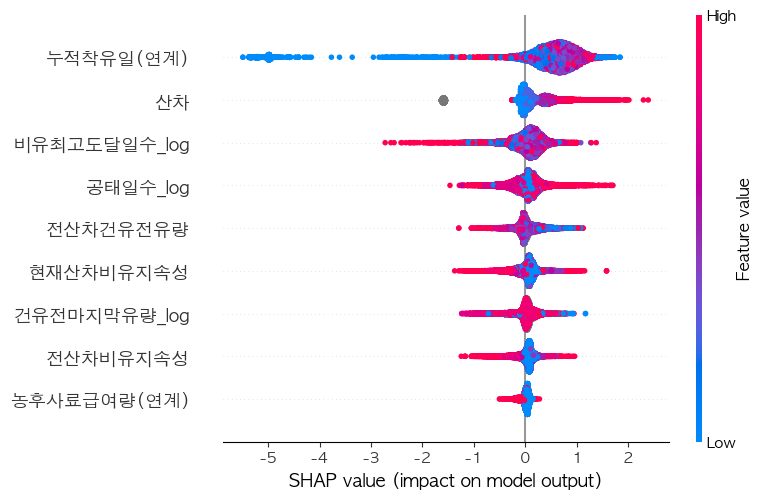

In [40]:
# SHAP 적용
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Plot
shap.summary_plot(shap_values, X)


In [41]:
# mean absolute shap value per feature
shap_importance = np.abs(shap_values).mean(axis=0)
print(shap_importance)
shap_df = pd.DataFrame({
    'feature': X.columns,
    'shap_importance': shap_importance
}).sort_values(by='shap_importance', ascending=False)

print(shap_df)

[0.74070301 0.13025971 0.15751038 0.21591157 0.14160071 0.15838876
 0.25487053 0.05433607 0.20230532]
        feature  shap_importance
0     누적착유일(연계)         0.740703
6            산차         0.254871
3  비유최고도달일수_log         0.215912
8      공태일수_log         0.202305
5      전산차건유전유량         0.158389
2     현재산차비유지속성         0.157510
4  건유전마지막유량_log         0.141601
1      전산차비유지속성         0.130260
7   농후사료급여량(연계)         0.054336


In [42]:
shap_by_feat = shap_df.set_index('feature')
shap_by_feat

,shap_importance
feature,
누적착유일(연계),0.740703
산차,0.254871
비유최고도달일수_log,0.215912
공태일수_log,0.202305
전산차건유전유량,0.158389
현재산차비유지속성,0.157510
건유전마지막유량_log,0.141601
전산차비유지속성,0.130260
농후사료급여량(연계),0.054336


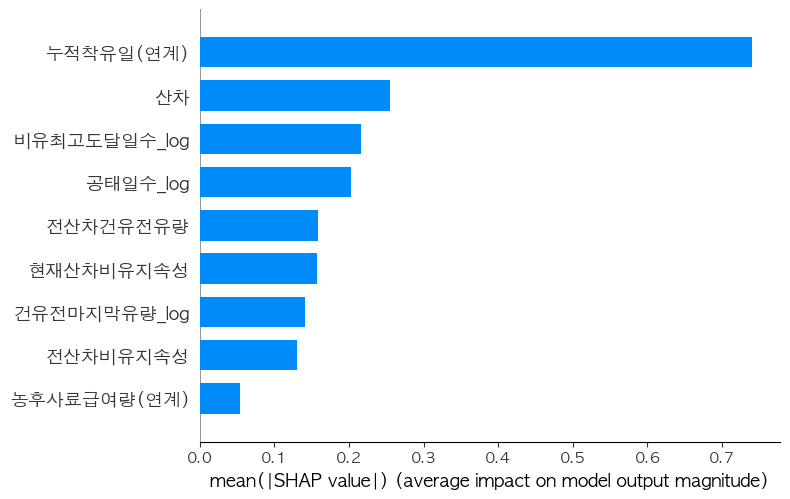

In [43]:
# Plot
shap.summary_plot(shap_values, X, plot_type='bar')

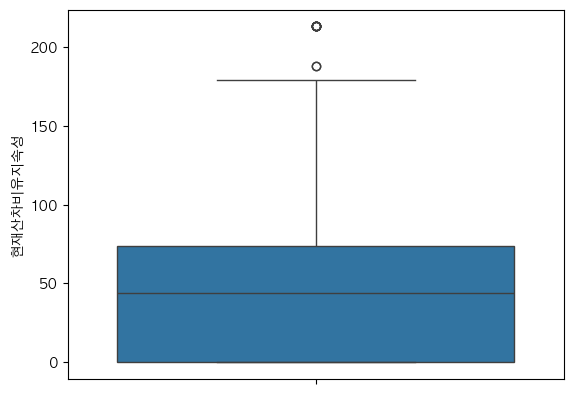

In [45]:
sns.boxplot(data=X, y='현재산차비유지속성')
plt.show()

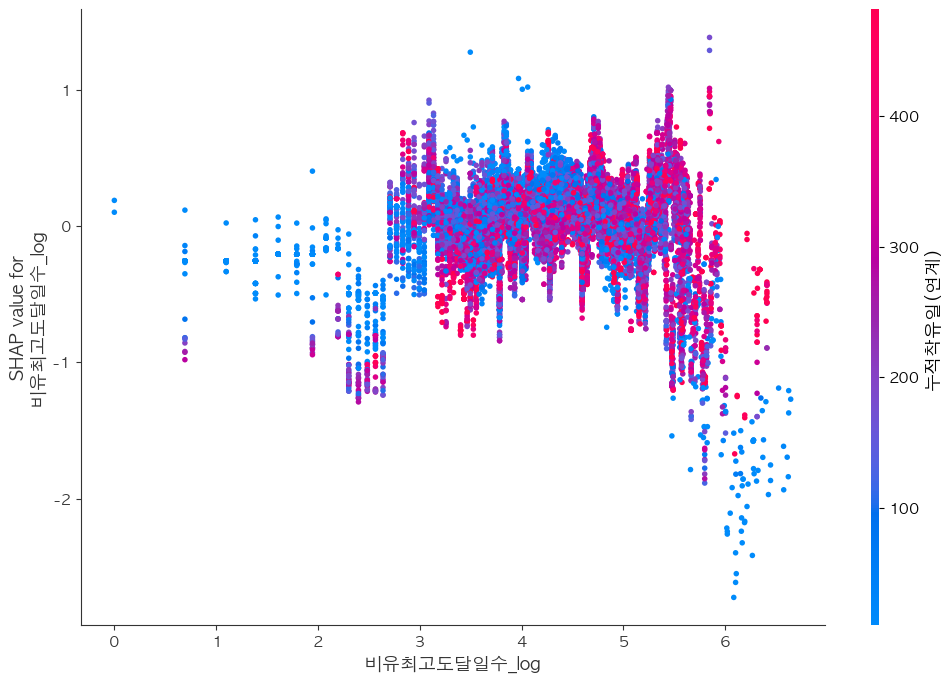

In [59]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
shap.dependence_plot(3, shap_values, X, feature_names, ax=ax)
plt.show()

In [47]:
print("\n" + "="*60)
print("📊 변수 중요도 Top 10")
print("="*60)

final_model = model
feature_names = list(X_train.columns)

n_features_used = len(final_model.feature_importances_)
feature_names = feature_names[:n_features_used]

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print(importance_df.head(10).to_string(index=False))


📊 변수 중요도 Top 10
     feature  importance
비유최고도달일수_log        5165
   누적착유일(연계)        4905
    공태일수_log        4707
    전산차건유전유량        3630
   현재산차비유지속성        3325
건유전마지막유량_log        3015
    전산차비유지속성        2882
          산차         831
 농후사료급여량(연계)         460


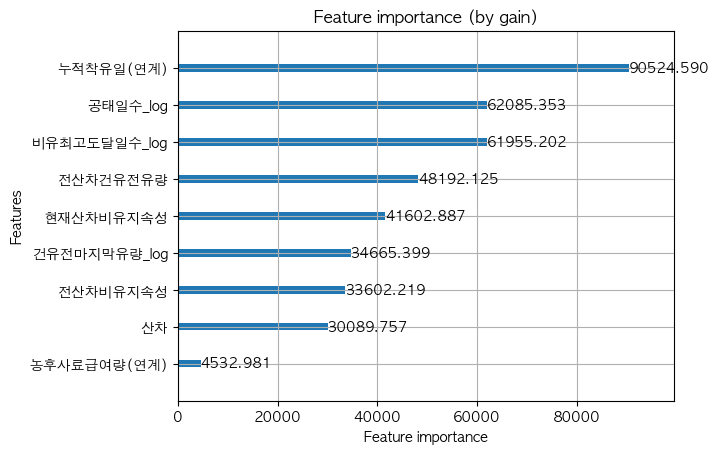

In [48]:
lgb.plot_importance(model, importance_type='gain', max_num_features=9)
plt.title('Feature importance (by gain)')
plt.show()